# Opioid Data Project

*This project uses several machine learning models to gain insights from opioid data available from data.gov.*


I looked at the data set titled "Accidental Drug Related Deaths 2012-June 2017" available at: https://catalog.data.gov/dataset/accidental-drug-related-deaths-january-2012-sept-2015.

In particular, I attempted to answer the following question:
"Given an accidental drug overdose related death, can we predict the drug that was used? i.e. whether the overdose is related to a street drug (such as Heroin, Cocaine), or a prescription drug (such as Fentanyl, Oxycodone, Oxymorphone, EtOH, Hydrocodone, Benzodiazepine, Methadone, Amphet, Tramad, Morphine)?"


## Setup 

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [391]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# For handling data frames
import io
import requests
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.exists(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)

    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the Data

In [1]:
# Everytime we run this notebook, we get the updated data from the following webpage. 
DOWNLOAD_URL = "https://data.ct.gov/api/views/rybz-nyjw/rows.csv"
DATA_SET_FILE = "Accidental_Drug_Related_Deaths__2012-June_2017.csv"


def fetch_opioid_data():
    s=requests.get(DOWNLOAD_URL).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

In [393]:
data = fetch_opioid_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3583 entries, 0 to 3582
Data columns (total 32 columns):
CaseNumber               3583 non-null object
Date                     3581 non-null object
Sex                      3580 non-null object
Race                     3573 non-null object
Age                      3581 non-null float64
Residence City           3490 non-null object
Residence State          1663 non-null object
Residence County         2885 non-null object
Death City               3579 non-null object
Death State              1702 non-null object
Death County             2405 non-null object
Location                 3561 non-null object
DescriptionofInjury      998 non-null object
InjuryPlace              3506 non-null object
ImmediateCauseA          3581 non-null object
Heroin                   1936 non-null object
Cocaine                  998 non-null object
Fentanyl                 1114 non-null object
Oxycodone                491 non-null object
Oxymorphone          

## Clean the Data

In [394]:
data.isnull().any()

CaseNumber               False
Date                      True
Sex                       True
Race                      True
Age                       True
Residence City            True
Residence State           True
Residence County          True
Death City                True
Death State               True
Death County              True
Location                  True
DescriptionofInjury       True
InjuryPlace               True
ImmediateCauseA           True
Heroin                    True
Cocaine                   True
Fentanyl                  True
Oxycodone                 True
Oxymorphone               True
EtOH                      True
Hydrocodone               True
Benzodiazepine            True
Methadone                 True
Amphet                    True
Tramad                    True
Morphine (not heroin)     True
Other                     True
Any Opioid                True
MannerofDeath             True
AmendedMannerofDeath      True
DeathLoc                 False
dtype: b

In [319]:
# Remove all the rows where the age and the MannerofDeath are missing
data = data.dropna(subset=["Age", "MannerofDeath"])

In [320]:
data.describe()

,Age
count,3574.000000
mean,41.982373
std,12.325512
min,14.000000
25%,32.000000
50%,43.000000
75%,52.000000
max,87.000000


In [321]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3574 entries, 0 to 3582
Data columns (total 32 columns):
CaseNumber               3574 non-null object
Date                     3574 non-null object
Sex                      3573 non-null object
Race                     3566 non-null object
Age                      3574 non-null float64
Residence City           3484 non-null object
Residence State          1663 non-null object
Residence County         2881 non-null object
Death City               3573 non-null object
Death State              1702 non-null object
Death County             2399 non-null object
Location                 3555 non-null object
DescriptionofInjury      998 non-null object
InjuryPlace              3498 non-null object
ImmediateCauseA          3572 non-null object
Heroin                   1935 non-null object
Cocaine                  994 non-null object
Fentanyl                 1113 non-null object
Oxycodone                490 non-null object
Oxymorphone          

In [322]:
"""
The DeathLoc includes the city, state as well as the lattitude (lat) and longitude (lon) values. 
By extracting the lat and lon values, we can display the data on a map along with other features.

I have used a regular expression to extract the lat and lon values.
"""
import re

data['DeathLoc2'] = data['DeathLoc'].apply( lambda x: re.sub("\s*[A-Za-z()\s]+\s*", "", str(x)) );

data['lat'] = data['DeathLoc2'].apply( lambda x: x.split(',')[1] )
data['lon'] = data['DeathLoc2'].apply( lambda x: x.split(',')[-1] )

In [323]:
data['lat'].describe()

count          3574
unique          197
top       41.765775
freq            367
Name: lat, dtype: object

In [324]:
data['lon'].describe()

count           3574
unique           196
top       -72.673356
freq             367
Name: lon, dtype: object

In [325]:
#Convert the lat and lon columns from object to numerical values

data['lat'] = pd.to_numeric(data['lat'], errors='coerce').fillna(0)

data['lon'] = pd.to_numeric(data['lon'], errors='coerce').fillna(0)

In [326]:
data['lat'].describe()

count    3574.000000
mean       41.498188
std         1.924222
min       -72.651713
25%        41.316843
50%        41.554261
75%        41.765775
max        42.025992
Name: lat, dtype: float64

In [327]:
data['lon'].describe()

count    3574.000000
mean      -72.803145
std         0.391349
min       -73.628549
25%       -73.057564
50%       -72.824947
75%       -72.643785
max       -71.808899
Name: lon, dtype: float64

In [328]:
# To fix the error due to incorrect data split, we remove the minimum lat values.

data = data[data['lat'] != data['lat'].min()]

# Now we check the lat info to see if the min value is as expected

data['lat'].describe()

count    3573.000000
mean       41.530136
std         0.234034
min        41.026526
25%        41.316843
50%        41.554261
75%        41.765775
max        42.025992
Name: lat, dtype: float64

## Handle the Text and Categorical Features

Many of the columns in the dataset have textual values, therefore, we need to convert to categorical values.

We can use Pandas' `factorize()` method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

Now let's preprocess the categorical input feature, `Sex`:

In [329]:
data['Sex'].head(10)

0    Female
1      Male
2      Male
3    Female
4    Female
5    Female
6      Male
7      Male
8    Female
9      Male
Name: Sex, dtype: object

In [330]:
sex_categories_encoded, sex_categories = data['Sex'].factorize()
data['Sex_Encoded'] = sex_categories_encoded
data['Sex_Encoded'].head(10)

0    0
1    1
2    1
3    0
4    0
5    0
6    1
7    1
8    0
9    1
Name: Sex_Encoded, dtype: int64

In [331]:
sex_categories

Index(['Female', 'Male'], dtype='object')

Let's preprocess the categorical input feature, `Race`:

In [332]:
data['Race'].head(10)

0              White
1              White
2              White
3              White
4              White
5              White
6              White
7    Hispanic, White
8              White
9              White
Name: Race, dtype: object

In [333]:
race_categories_encoded, race_categories = data['Race'].factorize()
data['Race_Encoded'] = race_categories_encoded
data['Race_Encoded'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: Race_Encoded, dtype: int64

In [334]:
race_categories

Index(['White', 'Hispanic, White', 'Unknown', 'Black', 'Asian, Other', 'Other',
       'Hispanic, Black', 'Native American, Other', 'Asian Indian', 'Chinese',
       'Hawaiian'],
      dtype='object')

Let's preprocess the categorical input feature, `MannerofDeath`:

In [335]:
data['MannerofDeath'].head(10)

0    Accident
1    Accident
2    Accident
3    Accident
4    Accident
5    Accident
6     Pending
7    Accident
8    Accident
9    Accident
Name: MannerofDeath, dtype: object

In [336]:
MannerofDeath_categories_encoded, MannerofDeath_categories = data['MannerofDeath'].factorize()

In [337]:
MannerofDeath_categories

Index(['Accident', 'Pending', 'accident', 'Natural', 'ACCIDENT'], dtype='object')

In [338]:
# This is a manual step to clean up, and consolidate the categories
# since there are some redundant categories for Accident.
manner_of_death_classification_dict = {
    'Accident': ['Accident','accident','ACCIDENT'], 
    'Pending': ['Pending'], 
    'Natural': ['Natural']}
manner_of_death_classification = {v: k for k,vv in manner_of_death_classification_dict.items() for v in vv}
manner_of_death_classification

{'ACCIDENT': 'Accident',
 'Accident': 'Accident',
 'Natural': 'Natural',
 'Pending': 'Pending',
 'accident': 'Accident'}

In [339]:
data['MannerofDeath'] = data['MannerofDeath'].apply( lambda x: manner_of_death_classification[x])

In [340]:
# Now that the MannerofDeath categories are cleaned up, let's run the factorize again, 
# and update the manner_of_death categories

manner_of_death_final_categories_encoded, manner_of_death_final_categories = data['MannerofDeath'].factorize()
data['MannerofDeath_Encoded'] = manner_of_death_final_categories_encoded
data['MannerofDeath_Encoded'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    1
7    0
8    0
9    0
Name: MannerofDeath_Encoded, dtype: int64

In [341]:
manner_of_death_final_categories

Index(['Accident', 'Pending', 'Natural'], dtype='object')

Let's preprocess the categorical input feature, `Location`:

In [342]:
data['Location'].head(10)

0    Residence
1     Hospital
2    Residence
3    Residence
4        Other
5     Hospital
6     Hospital
7    Residence
8     Hospital
9    Residence
Name: Location, dtype: object

In [343]:
death_location_categories_encoded, death_location_categories = data['Location'].factorize()
data['Location_Encoded'] = death_location_categories_encoded
data['Location_Encoded'].head(10)

0    0
1    1
2    0
3    0
4    2
5    1
6    1
7    0
8    1
9    0
Name: Location_Encoded, dtype: int64

In [344]:
death_location_categories

Index(['Residence', 'Hospital', 'Other', 'Convalescent Home', 'Hospice'], dtype='object')

Let's preprocess the categorical input feature, `InjuryPlace`:

In [345]:
data['InjuryPlace'].head(10)

0                     NaN
1               Residence
2               Residence
3               Residence
4    Residential Building
5               Residence
6                     NaN
7               Residence
8               Residence
9               Residence
Name: InjuryPlace, dtype: object

In [346]:
injury_place_categories_encoded, injury_place_categories = data['InjuryPlace'].factorize()
data['InjuryPlace_Encoded'] = injury_place_categories_encoded
data['InjuryPlace_Encoded'].head(10)

0   -1
1    0
2    0
3    0
4    1
5    0
6   -1
7    0
8    0
9    0
Name: InjuryPlace_Encoded, dtype: int64

In [347]:
injury_place_categories

Index(['Residence', 'Residential Building', 'Other', 'Restaurant',
       'Automobile', 'Hospital', 'Unknown', 'Hotel or Motel',
       'Other indoor Area', 'Other, Industrial Area', 'Other (unknown)',
       'Other, Other Outdoor Area', 'Other, Public Buildings', 'In Vehicle',
       'Store or Shopping Area', 'Other, Residential Institution', 'Alleyway',
       'Office Building', 'Driveway', 'Hospital or Emergency Room',
       'Apartment', 'Parking Lot', 'Public Park, Urban or Suburban', 'Casino',
       'School, Primary or Secondary', 'Bar or Night Club', 'Campgrounds',
       'Boat/Marina', 'Forest, Wooded Area', 'Sidewalk', 'Porch', 'Field',
       'House', 'Street', 'Roadway', 'Halfway House',
       'Train or Subway Station', 'Public Park', 'Beach',
       'Other, Park or Recreational Area', 'Nursing Home',
       'Detoxification Center', 'Rest Home', 'Rehab House', 'Garage',
       'Building', 'Friend's Residence', 'homeless shelter', 'Backyard',
       'University or College',

Let's preprocess the different drug types available in the data, and create 
categorical input feature called `DrugType`, which specifies whether it is a `street_drug` 
or a `prescription_drug`.

In [348]:
# Combine the drugs found in the decesed individual into either street or prescription drugs.

drug_types = { 
'street_drug': 
    ['Heroin', 'Cocaine'],
'prescription_drug' : 
    ['Fentanyl', 'Oxycodone', 'Oxymorphone','EtOH','Hydrocodone', 'Benzodiazepine', 'Methadone', 'Amphet', 'Tramad', 'Morphine (not heroin)', 'Other', 'Any Opioid']}

drug_types

{'prescription_drug': ['Fentanyl',
  'Oxycodone',
  'Oxymorphone',
  'EtOH',
  'Hydrocodone',
  'Benzodiazepine',
  'Methadone',
  'Amphet',
  'Tramad',
  'Morphine (not heroin)',
  'Other',
  'Any Opioid'],
 'street_drug': ['Heroin', 'Cocaine']}

In [349]:
drug_type_list = {v: k for k,vv in drug_types.items() for v in vv}

In [350]:
def label_drug (row):
    for k, v in drug_type_list.items():
        if row[k]  == 'Y' or row[k] == 'y':
            return v

data['DrugType'] = data.apply (lambda row: label_drug (row),axis=1)

data['DrugType'].value_counts()

street_drug          1794
prescription_drug    1720
Name: DrugType, dtype: int64

In [351]:
data['DrugType'].head(10)

0    prescription_drug
1    prescription_drug
2    prescription_drug
3          street_drug
4          street_drug
5    prescription_drug
6          street_drug
7          street_drug
8          street_drug
9          street_drug
Name: DrugType, dtype: object

Let's apply the same preprocess the categorical input feature, `DrugType`:

In [352]:
drug_type_categories_encoded, drug_type_categories = data['DrugType'].factorize()
data['DrugType_Encoded'] = drug_type_categories_encoded
data['DrugType_Encoded'].head(10)

0    0
1    0
2    0
3    1
4    1
5    0
6    1
7    1
8    1
9    1
Name: DrugType_Encoded, dtype: int64

In [353]:
drug_type_categories

Index(['prescription_drug', 'street_drug'], dtype='object')

# Visualize the Data

## Histogram Plots

Saving figure histogram_plots


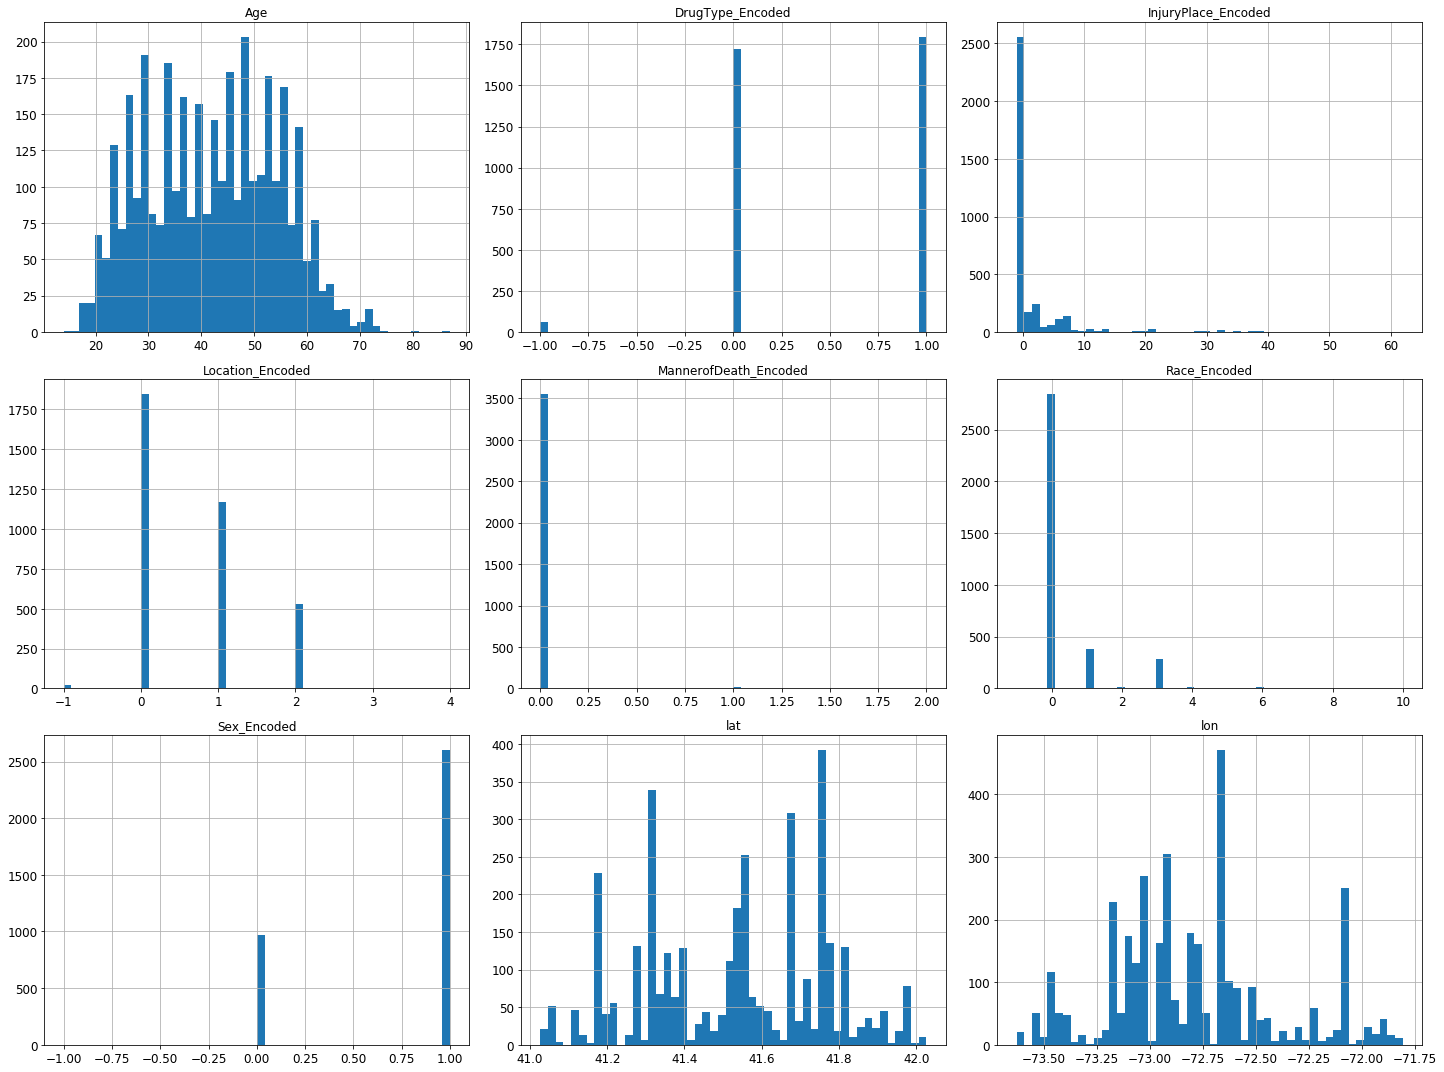

In [354]:
# Generate the histogram plots of the different numerical data

%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
save_fig("histogram_plots")
plt.show()

## Scatter Plots

### Overall Occurences

Saving figure occurences_visualization_plot


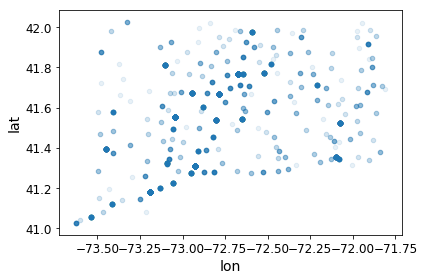

In [355]:
# Scatter plot of the Age of the individuals who died plotted against the lat and lon values
# Notice the outline of Connecticut in this plot.

data.plot(kind="scatter", x="lon", y="lat", alpha=0.1)
save_fig("occurences_visualization_plot")

### Age

Saving figure age_color_scatterplot


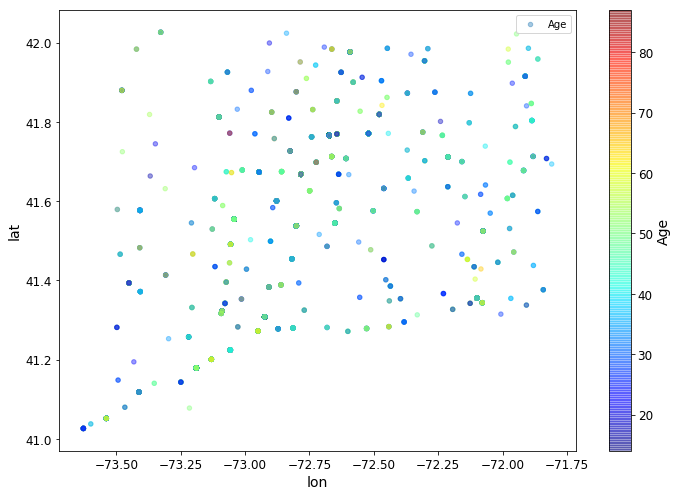

In [356]:
# Even better plot with a color map showing the age of the individuals who died.

data.plot(kind="scatter", x="lon", y="lat", alpha=0.4,
    label="Age", figsize=(10,7),
    c="Age", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("age_color_scatterplot")

### Drug Type

Saving figure drug_type_color_scatterplot


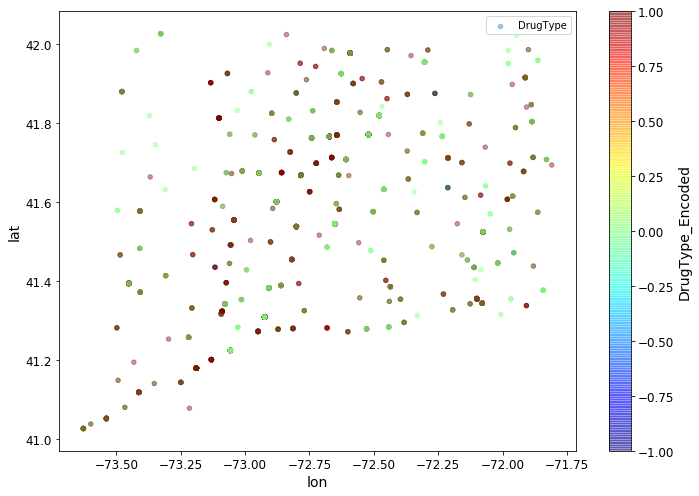

In [357]:
# Even better plot with a color map showing the drug used by the individuals who died.
# TODO: there may be a bug here: there are only two drug types, but why does it show a spectrum?

data.plot(kind="scatter", x="lon", y="lat", alpha=0.4,
    label="DrugType", figsize=(10,7),
    c="DrugType_Encoded", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("drug_type_color_scatterplot")

# Train/Test Split

 ## Gather Statistics

In [358]:
data["DrugType_Encoded"].value_counts()

# DrugType encodings
# 0 : prescription_drug
# 1 : street_drug
# -1 : No Information about the drug
# (check the drug_type_categories variable)

 1    1794
 0    1720
-1      59
Name: DrugType_Encoded, dtype: int64

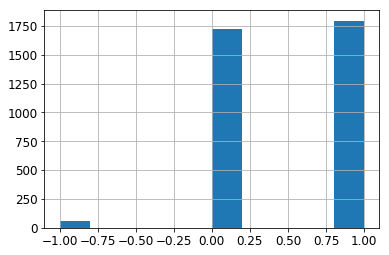

In [359]:
data["DrugType_Encoded"].hist()

## Stratified Shuffle Split

In [360]:
""" StratifiedShuffleSplit splits the dataset better than randomly splitting the dataset.
"""
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["DrugType_Encoded"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [361]:
# Check the portion of each category of the DrugType in test set values
strat_test_set["DrugType_Encoded"].value_counts() / len(strat_test_set)

 1.0    0.503497
 0.0    0.481119
-1.0    0.011189
Name: DrugType_Encoded, dtype: float64

In [362]:
# Check the portion of each category of the DrugType in original data set

data["DrugType_Encoded"].value_counts() / len(data)

 1    0.502099
 0    0.481388
-1    0.016513
Name: DrugType_Encoded, dtype: float64

## Random Split

In [363]:
# Only importing to compare the split with Stratified Split

from sklearn.model_selection import train_test_split

def drug_type_category_proportions(df):
    return df["DrugType_Encoded"].value_counts() / len(df)

random_train_set, random_test_set = train_test_split(data, test_size=0.2, random_state=42)

## Compare the Two Splits

In [364]:
compare_props = pd.DataFrame({
    "Overall": drug_type_category_proportions(data),
    "Stratified": drug_type_category_proportions(strat_test_set),
    "Random": drug_type_category_proportions(random_test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [365]:
# Comparing the two split approaches
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
-1,0.016513,0.016783,0.011189,1.638023,-32.241318
0,0.481388,0.458741,0.481119,-4.704505,-0.055944
1,0.502099,0.524476,0.503497,4.456580,0.278317


# Prepare the Data for Machine Learning Algorithms

## Drop the Feature Explored

We need to remove the `DrugType_Encoded` column from the train and test sets

In [366]:
# The stratified split apporach is definitely better. 
# Therefore using that split.

train_set = strat_train_set.drop("DrugType_Encoded", axis=1) # drop labels for training set
opioid_labels = strat_train_set["DrugType_Encoded"].copy()

test_set = strat_test_set.copy()

In [395]:
train_set.isnull().any()

CaseNumber               True
Date                     True
Sex                      True
Race                     True
Age                      True
Residence City           True
Residence State          True
Residence County         True
Death City               True
Death State              True
Death County             True
Location                 True
DescriptionofInjury      True
InjuryPlace              True
ImmediateCauseA          True
Heroin                   True
Cocaine                  True
Fentanyl                 True
Oxycodone                True
Oxymorphone              True
EtOH                     True
Hydrocodone              True
Benzodiazepine           True
Methadone                True
Amphet                   True
Tramad                   True
Morphine (not heroin)    True
Other                    True
Any Opioid               True
MannerofDeath            True
AmendedMannerofDeath     True
DeathLoc                 True
DeathLoc2                True
lat       

## Explore the Split of Data Set

In [367]:
test_set.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,DeathLoc2,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded,DrugType,DrugType_Encoded
1697,13-3629,03/02/2013,Male,White,28.0,BALTIC,NaN,NEW LONDON,SALEM,NaN,...,",41.487106,-72.274406",41.487106,-72.274406,1.0,0.0,0.0,2.0,2.0,street_drug,1.0
959,14-4334,03/16/2014,Male,White,66.0,NORTH HAVEN,NaN,NaN,NORTH HAVEN,NaN,...,",41.38864,-72.860826",41.388640,-72.860826,1.0,0.0,0.0,0.0,0.0,street_drug,1.0
1690,14-5049,03/29/2014,Male,White,24.0,MANCHESTER,NaN,NaN,HARTFORD,NaN,...,",41.765775,-72.673356",41.765775,-72.673356,1.0,0.0,0.0,1.0,0.0,street_drug,1.0
2558,16-2914,11/13/2016,Male,"Hispanic, Black",47.0,HARTFORD,NaN,HARTFORD,HARTFORD,NaN,...,",41.765775,-72.673356",41.765775,-72.673356,1.0,6.0,0.0,0.0,0.0,street_drug,1.0
322,14-18905,12/17/2014,Male,White,54.0,SALISBURY,NaN,NaN,SALISBURY,NaN,...,",41.983411,-73.422268",41.983411,-73.422268,1.0,0.0,0.0,0.0,0.0,street_drug,1.0


In [368]:
train_set.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,DeathLoc,DeathLoc2,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded,DrugType
1975,14-5197,04/01/2014,Male,White,35.0,BETHEL,NaN,NaN,BETHEL,NaN,...,"BETHEL, CT\n(41.371727, -73.407448)",",41.371727,-73.407448",41.371727,-73.407448,1.0,0.0,0.0,2.0,7.0,street_drug
188,13-8677,06/08/2013,Male,White,35.0,MERIDEN,NaN,NEW HAVEN,MERIDEN,NaN,...,"MERIDEN, CT\n(41.537589, -72.8011)",",41.537589,-72.8011",41.537589,-72.801100,1.0,0.0,0.0,0.0,0.0,prescription_drug
328,13-8427,06/03/2013,Female,White,26.0,STRATFORD,NaN,FAIRFIELD,BRIDGEPORT,NaN,...,"BRIDGEPORT, CT\n(41.179195, -73.189476)",",41.179195,-73.189476",41.179195,-73.189476,0.0,0.0,0.0,1.0,0.0,street_drug
1965,15-9821,06/13/2015,Male,White,34.0,WEBSTER,MA,WORCESTER,THOMPSON,CT,...,"THOMPSON, CT\n(41.958546, -71.86272)",",41.958546,-71.86272",41.958546,-71.862720,1.0,0.0,0.0,2.0,-1.0,prescription_drug
991,14-15997,10/26/2014,Male,White,57.0,WEST HAVEN,NaN,NaN,WEST HAVEN,NaN,...,"WEST HAVEN, CT\n(41.272336, -72.949817)",",41.272336,-72.949817",41.272336,-72.949817,1.0,0.0,0.0,0.0,0.0,prescription_drug


## Seperate the Data Frame Into Numerical and Categorical Frames

### Numerical Frame

In [369]:
train_set_num = train_set.filter(['Age','lat','lon', 'Sex_Encoded', 'Race_Encoded', 'MannerofDeath_Encoded', 'Location_Encoded', 'InjuryPlace_Encoded'], axis=1)
train_set_num.head()

,Age,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded
1975,35.0,41.371727,-73.407448,1.0,0.0,0.0,2.0,7.0
188,35.0,41.537589,-72.801100,1.0,0.0,0.0,0.0,0.0
328,26.0,41.179195,-73.189476,0.0,0.0,0.0,1.0,0.0
1965,34.0,41.958546,-71.862720,1.0,0.0,0.0,2.0,-1.0
991,57.0,41.272336,-72.949817,1.0,0.0,0.0,0.0,0.0


In [370]:
# Find the rows that have NaN values
sample_incomplete_rows = train_set[train_set.isnull().any(axis=1)].head()
sample_incomplete_rows

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,DeathLoc,DeathLoc2,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded,DrugType
1975,14-5197,04/01/2014,Male,White,35.0,BETHEL,NaN,NaN,BETHEL,NaN,...,"BETHEL, CT\n(41.371727, -73.407448)",",41.371727,-73.407448",41.371727,-73.407448,1.0,0.0,0.0,2.0,7.0,street_drug
188,13-8677,06/08/2013,Male,White,35.0,MERIDEN,NaN,NEW HAVEN,MERIDEN,NaN,...,"MERIDEN, CT\n(41.537589, -72.8011)",",41.537589,-72.8011",41.537589,-72.801100,1.0,0.0,0.0,0.0,0.0,prescription_drug
328,13-8427,06/03/2013,Female,White,26.0,STRATFORD,NaN,FAIRFIELD,BRIDGEPORT,NaN,...,"BRIDGEPORT, CT\n(41.179195, -73.189476)",",41.179195,-73.189476",41.179195,-73.189476,0.0,0.0,0.0,1.0,0.0,street_drug
1965,15-9821,06/13/2015,Male,White,34.0,WEBSTER,MA,WORCESTER,THOMPSON,CT,...,"THOMPSON, CT\n(41.958546, -71.86272)",",41.958546,-71.86272",41.958546,-71.862720,1.0,0.0,0.0,2.0,-1.0,prescription_drug
991,14-15997,10/26/2014,Male,White,57.0,WEST HAVEN,NaN,NaN,WEST HAVEN,NaN,...,"WEST HAVEN, CT\n(41.272336, -72.949817)",",41.272336,-72.949817",41.272336,-72.949817,1.0,0.0,0.0,0.0,0.0,prescription_drug


In [371]:
# Remove the not useful columns with NaN values
# train_set.drop("Residence State", axis=1, inplace=True)
# train_set.drop("Residence County", axis=1, inplace=True)
# train_set.drop("Death State", axis=1, inplace=True)
# train_set.drop("InjuryPlace", axis=1, inplace=True)
# train_set.drop("DescriptionofInjury", axis=1, inplace=True)


In [372]:
train_set_cat = train_set.filter(['Sex','Race','MannerofDeath','Location', 'InjuryPlace', 'DrugType'], axis=1)
train_set_cat.head()

,Sex,Race,MannerofDeath,Location,InjuryPlace,DrugType
1975,Male,White,Accident,Other,Hotel or Motel,street_drug
188,Male,White,Accident,Residence,Residence,prescription_drug
328,Female,White,Accident,Hospital,Residence,street_drug
1965,Male,White,Accident,Other,NaN,prescription_drug
991,Male,White,Accident,Residence,Residence,prescription_drug


In [373]:
# TODO: This may not be necessary.
train_set_cat_encoded = train_set.filter(['Sex_Encoded','Race_Encoded','MannerofDeath_Encoded','Location_Encoded', 'InjuryPlace_Encoded', 'DrugType_Encoded'], axis=1)
train_set_cat_encoded.head()

,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded
1975,1.0,0.0,0.0,2.0,7.0
188,1.0,0.0,0.0,0.0,0.0
328,0.0,0.0,0.0,1.0,0.0
1965,1.0,0.0,0.0,2.0,-1.0
991,1.0,0.0,0.0,0.0,0.0


## Encode the Categories

In [374]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# https://github.com/scikit-learn/scikit-learn/pull/9151

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

The `CategoricalEncoder` expects a 2D array containing one or more categorical input features. We need to reshape `sex_categories` to a 2D array:

In [375]:
cat_encoder = CategoricalEncoder()
drug_type_categories_reshaped = drug_type_categories.values.reshape(-1, 1)
drug_type_categories_1hot = cat_encoder.fit_transform(drug_type_categories_reshaped)
drug_type_categories_1hot

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [376]:
drug_type_categories_1hot.toarray()

array([[ 1.,  0.],
       [ 0.,  1.]])

The default encoding is one-hot, and it returns a sparse array. You can use `toarray()` to get a dense array:

Alternatively, we can specify the encoding to be `"onehot-dense"` to get a dense matrix rather than a sparse matrix:

In [377]:
cat_encoder.categories_

[array(['prescription_drug', 'street_drug'], dtype=object)]

In [378]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
drug_type_categories_1hot = cat_encoder.fit_transform(drug_type_categories_reshaped)
drug_type_categories_1hot

array([[ 1.,  0.],
       [ 0.,  1.]])

# Gather Insights

In [379]:
corr_matrix = train_set.corr()
corr_matrix

,Age,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded
Age,1.000000,-0.014225,0.005794,-0.061070,0.073162,0.008254,-0.091706,-0.029072
lat,-0.014225,1.000000,0.426430,-0.002626,-0.066387,-0.009361,-0.037885,-0.038257
lon,0.005794,0.426430,1.000000,0.011824,-0.052410,-0.025875,-0.053294,-0.033164
Sex_Encoded,-0.061070,-0.002626,0.011824,1.000000,0.035650,-0.003227,0.035024,0.052084
Race_Encoded,0.073162,-0.066387,-0.052410,0.035650,1.000000,0.004995,0.054284,0.029439
MannerofDeath_Encoded,0.008254,-0.009361,-0.025875,-0.003227,0.004995,1.000000,0.006355,-0.022378
Location_Encoded,-0.091706,-0.037885,-0.053294,0.035024,0.054284,0.006355,1.000000,0.350838
InjuryPlace_Encoded,-0.029072,-0.038257,-0.033164,0.052084,0.029439,-0.022378,0.350838,1.000000


In [380]:
# Corelation between the InjuryPlace and other parameters.
# It can be reasoned that there is a good corelation between the injury place,
# and the location (i.e house, hospital) the person died.

corr_matrix["InjuryPlace_Encoded"].sort_values(ascending=False)

InjuryPlace_Encoded      1.000000
Location_Encoded         0.350838
Sex_Encoded              0.052084
Race_Encoded             0.029439
MannerofDeath_Encoded   -0.022378
Age                     -0.029072
lon                     -0.033164
lat                     -0.038257
Name: InjuryPlace_Encoded, dtype: float64

In [381]:
train_set.describe()

,Age,lat,lon,Sex_Encoded,Race_Encoded,MannerofDeath_Encoded,Location_Encoded,InjuryPlace_Encoded
count,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000,2851.000000
mean,41.780077,41.529346,-72.804288,0.724307,0.412487,0.003508,0.620835,2.441950
std,12.364821,0.234544,0.389758,0.446941,1.039723,0.059131,0.739161,7.270878
min,14.000000,41.026526,-73.628549,0.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,31.000000,41.313993,-73.056564,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,41.554261,-72.824947,1.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,41.765775,-72.643785,1.000000,0.000000,0.000000,1.000000,1.000000
max,81.000000,42.025992,-71.808899,1.000000,10.000000,1.000000,4.000000,62.000000


# Build the Machine Learning Pipeline

Now let's build a pipeline for preprocessing the numerical attributes:

In [382]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

train_set_num_tr = num_pipeline.fit_transform(train_set_num)

In [383]:
train_set_num_tr

array([[-0.5491485 , -0.67321694, -1.54955938, ..., -0.05925568,
         1.86891514,  0.6285074 ],
       [-0.5491485 ,  0.03493448,  0.00832181, ..., -0.05925568,
        -0.83831216, -0.3354545 ],
       [-1.27804048, -1.49523651, -0.98952706, ..., -0.05925568,
         0.51530149, -0.3354545 ],
       ..., 
       [ 1.07061146,  0.10611594, -0.61336566, ..., -0.05925568,
         0.51530149, -0.3354545 ],
       [ 0.09875548, -0.80022241, -0.70387388, ..., -0.05925568,
        -0.83831216, -0.3354545 ],
       [-1.19705248,  0.10611594, -0.61336566, ..., -0.05925568,
        -0.83831216, -0.3354545 ]])

And a transformer to just select a subset of the Pandas DataFrame columns:

In [384]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [385]:
# TODO: Investigate how to use the CategoricalEncoder.

num_attribs = list(train_set_num)
#cat_attribs = list(train_set_cat_encoded)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# cat_pipeline = Pipeline([
#         ('selector', DataFrameSelector(cat_attribs)),
#         ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
#     ])

In [386]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
#         ("cat_pipeline", cat_pipeline),
    ])

In [387]:
train_set_prepared = full_pipeline.fit_transform(train_set)
train_set_prepared

array([[-0.5491485 , -0.67321694, -1.54955938, ..., -0.05925568,
         1.86891514,  0.6285074 ],
       [-0.5491485 ,  0.03493448,  0.00832181, ..., -0.05925568,
        -0.83831216, -0.3354545 ],
       [-1.27804048, -1.49523651, -0.98952706, ..., -0.05925568,
         0.51530149, -0.3354545 ],
       ..., 
       [ 1.07061146,  0.10611594, -0.61336566, ..., -0.05925568,
         0.51530149, -0.3354545 ],
       [ 0.09875548, -0.80022241, -0.70387388, ..., -0.05925568,
        -0.83831216, -0.3354545 ],
       [-1.19705248,  0.10611594, -0.61336566, ..., -0.05925568,
        -0.83831216, -0.3354545 ]])

In [388]:
train_set_prepared.shape

(2858, 8)

## Select and Train a Model 

### Model for Predicting `DrugType` 

In [390]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_set_prepared, opioid_labels)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [147]:
# let's try the full pipeline on a few training instances
some_data = train_set.iloc[:5]
some_labels = opioid_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

NameError: name 'opioid_labels' is not defined

Compare against the actual values:

In [1244]:
print("Labels:", list(some_labels))

Labels: [62.0, 25.0, 54.0, 30.0, 58.0]


In [1245]:
from sklearn.metrics import mean_squared_error

opioid_predictions = lin_reg.predict(train_set_prepared)
lin_mse = mean_squared_error(opioid_labels, opioid_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.4554371725665121e-14

In [1246]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(opioid_labels, opioid_predictions)
lin_mae

2.0539359032477494e-14

In [1247]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_set_prepared, opioid_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [1248]:
opioid_predictions = tree_reg.predict(train_set_prepared)
tree_mse = mean_squared_error(opioid_labels, opioid_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Fine-tuning the Model

In [1249]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_set_prepared, opioid_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [1250]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 0.56096819  0.          0.          0.          0.          0.11826248
  0.70957488  0.11826248  0.          0.        ]
Mean: 0.150706802759
Standard deviation: 0.248802821965


In [1251]:
lin_scores = cross_val_score(lin_reg, train_set_prepared, opioid_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  2.24883929e-03   3.82223205e-05   1.48783906e-14   2.51880689e-03
   6.85907685e-04   6.90729609e-04   2.28384990e-14   6.52910918e-04
   1.62985537e-03   4.07370285e-02]
Mean: 0.00492023005821
Standard deviation: 0.0119701807741


In [1252]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(train_set_prepared, opioid_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [1253]:
opioid_predictions = forest_reg.predict(train_set_prepared)
forest_mse = mean_squared_error(opioid_labels, opioid_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.12774624952897595

In [1254]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_set_prepared, opioid_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 0.29601077  0.00591312  0.00591312  0.01024183  0.01182625  0.1362587
  0.76920629  0.01961161  0.02135744  0.02442317]
Mean: 0.130076231992
Standard deviation: 0.230308663288


In [1255]:
scores = cross_val_score(lin_reg, train_set_prepared, opioid_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    1.000000e+01
mean     4.920230e-03
std      1.261768e-02
min      3.879309e-15
25%      1.918945e-04
50%      6.883186e-04
75%      2.094093e-03
max      4.073703e-02
dtype: float64

In [1256]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_set_prepared, opioid_labels)
opioid_predictions = svm_reg.predict(train_set_prepared)
svm_mse = mean_squared_error(opioid_labels, opioid_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

0.044602693803930143

In [1257]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(train_set_prepared, opioid_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [1258]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [1259]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [1260]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5.85041901171 {'max_features': 2, 'n_estimators': 3}
4.85237951411 {'max_features': 2, 'n_estimators': 10}
4.55305067219 {'max_features': 2, 'n_estimators': 30}
6.17740162217 {'max_features': 4, 'n_estimators': 3}
4.39485725966 {'max_features': 4, 'n_estimators': 10}
4.17434635813 {'max_features': 4, 'n_estimators': 30}
5.61058778385 {'max_features': 6, 'n_estimators': 3}
3.96266238114 {'max_features': 6, 'n_estimators': 10}
3.59566723823 {'max_features': 6, 'n_estimators': 30}
5.08045831427 {'max_features': 8, 'n_estimators': 3}
3.64947246466 {'max_features': 8, 'n_estimators': 10}
3.45191722337 {'max_features': 8, 'n_estimators': 30}
4.69925051049 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
4.5842823021 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
5.44508324706 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
4.42571866447 {'bootstrap': False, 'n_estimators': 10, 'max_features': 3}
4.91558869388 {'bootstrap': False, 'n_estimators': 3, 'max_feat

In [1261]:
pd.DataFrame(grid_search.cv_results_)

/Users/oshani/anaconda/envs/opioid-data-ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/oshani/anaconda/envs/opioid-data-ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/oshani/anaconda/envs/opioid-data-ml/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.014322,0.001303,-34.227403,-9.865596,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",17,-24.610528,...,-44.377040,-11.916010,-28.221444,-7.639120,-27.792177,-10.017684,0.001076,0.000095,9.104179,2.121668
1,0.040945,0.002460,-23.545587,-4.893773,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",12,-22.364493,...,-23.108706,-5.202227,-22.427443,-4.559130,-18.712207,-4.608745,0.001171,0.000157,4.082960,0.496780
2,0.119013,0.005922,-20.730270,-3.309823,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-22.836876,...,-19.280484,-3.393413,-21.651455,-3.188764,-16.585010,-3.375617,0.003725,0.000235,2.494938,0.099363
3,0.014229,0.001256,-38.160291,-9.856388,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",18,-39.248252,...,-38.019037,-8.945708,-38.170656,-9.291308,-28.417202,-9.299276,0.000960,0.000094,5.881869,1.232750
4,0.043982,0.002906,-19.314770,-3.859121,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",6,-19.825105,...,-15.914283,-3.537533,-23.333888,-4.382379,-13.572421,-3.481112,0.002603,0.000464,4.054103,0.395441
5,0.128844,0.006063,-17.425168,-2.844695,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",5,-19.477830,...,-15.050156,-2.664961,-19.370567,-3.048386,-13.272877,-2.829535,0.005242,0.000316,2.729360,0.124441
6,0.013579,0.001065,-31.478695,-8.224122,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",16,-38.744172,...,-18.666861,-5.066638,-28.560226,-7.769664,-32.106246,-10.511636,0.001058,0.000136,7.581386,1.821304
7,0.041104,0.002403,-15.702693,-3.212530,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",4,-16.519218,...,-11.250792,-2.598429,-19.705340,-3.535112,-12.946835,-3.428456,0.003164,0.000383,3.156308,0.345509
8,0.130549,0.006179,-12.928823,-2.135009,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-15.499332,...,-11.555046,-2.140167,-13.557408,-1.955248,-9.481813,-2.056407,0.004131,0.000605,2.162434,0.120121
9,0.014434,0.001305,-25.811057,-7.560427,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",14,-25.835859,...,-36.123349,-11.201128,-29.489784,-7.244571,-17.381981,-6.959870,0.001377,0.000182,6.666910,1.891648


In [1262]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_set_prepared, opioid_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b3428d0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b342f60>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [1263]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3.30002935598 {'max_features': 7, 'n_estimators': 180}
4.17163862265 {'max_features': 5, 'n_estimators': 15}
4.16426051232 {'max_features': 3, 'n_estimators': 72}
3.86688737401 {'max_features': 5, 'n_estimators': 21}
3.32922412684 {'max_features': 7, 'n_estimators': 122}
4.15755742834 {'max_features': 3, 'n_estimators': 75}
4.21701031089 {'max_features': 3, 'n_estimators': 88}
3.75968774954 {'max_features': 5, 'n_estimators': 100}
4.19848170308 {'max_features': 3, 'n_estimators': 150}
6.39051628513 {'max_features': 5, 'n_estimators': 2}


In [1264]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.95335533e-01,   4.66203263e-02,   4.96193343e-02,
         1.00698100e-05,   5.96266807e-03,   5.17233383e-03,
         1.30572869e-03,   5.71439863e-03,   2.60618740e-04,
         9.18107422e-03,   3.28905645e-03,   1.69811851e-03,
         3.15043733e-04,   1.25319302e-03,   8.87412303e-04,
         3.71659763e-04,   3.76884199e-05,   8.96694641e-05,
         6.65550015e-04,   6.71601325e-04,   2.21699021e-04,
         1.28518348e-03,   4.07175382e-03,   6.67140872e-03,
         4.63224605e-03,   6.96677193e-05,   1.52110451e-04,
         3.21697516e-03,   2.85734630e-03,   5.41941290e-03,
         4.46185779e-03,   2.16973705e-03,   1.68305843e-03,
         1.71686369e-04,   4.00742354e-03,   2.55370335e-05,
         1.02263816e-03,   3.74300068e-04,   2.83526077e-05,
         1.05652200e-03,   4.20953678e-05,   8.47473582e-04,
         4.44177730e-05,   1.06985935e-03,   1.04851249e-03,
         7.42123845e-04,   3.22104315e-04,   1.29654370e-03,
         5.52327932e-04,

In [1269]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Age", axis=1)
X_test_prepared = full_pipeline.transform(X_test)

y_test = test_set["Age"].copy()


KeyError: "['Age'] not in index"

In [1177]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("Age", axis=1)
y_test = test_set["Age"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

KeyError: "['Age'] not in index"

In [1176]:
final_rmse

NameError: name 'final_rmse' is not defined